In [1]:
import torch
import torchvision
import PIL
import os
from matplotlib import pyplot as plt
import cv2
import random
import warnings
import timm
from torch import nn
from tqdm import tqdm_notebook
from torchvision.models import mobilenet_v3_large

warnings.filterwarnings('ignore')

device='cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using: {device}')


Using: cuda


In [2]:
model=mobilenet_v3_large(weights='DEFAULT')
model.classifier[3]=nn.Linear(in_features=1280,out_features=2,bias=True)

In [3]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [4]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,src):
        self.src=src
        self.images=os.listdir(src)
        self.transforms=torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V1.transforms()
    
    def __len__(self):
        return len(self.images)

    def apply_mosaic(self,image, top_left_x, top_left_y, width, height, mosaic_size):
        """
        Apply a mosaic effect to a specific area of the image.
    
        :param image: The original image.
        :param top_left_x: Top left x-coordinate of the mosaic area.
        :param top_left_y: Top left y-coordinate of the mosaic area.
        :param width: Width of the mosaic area.
        :param height: Height of the mosaic area.
        :param mosaic_size: Size of the mosaic blocks.
        """
        # Extract the region of interest
        roi = image[top_left_y:top_left_y+height, top_left_x:top_left_x+width]
    
        #plt.imshow(roi)
        
        # Resize to mosaic size (downscale)
        roi_small = cv2.resize(roi, (mosaic_size, mosaic_size), interpolation=cv2.INTER_LINEAR)
    
        # Resize back to original size (upscale)
        mosaic = cv2.resize(roi_small, (width, height), interpolation=cv2.INTER_NEAREST)
        
        # Place the mosaic back into the original image
        image[top_left_y:top_left_y+height, top_left_x:top_left_x+width] = mosaic
        return image


    def __getitem__(self,idx):
        img=cv2.imread(self.src+"/"+self.images[idx])

        pixelize=random.randint(0,1)
        
        if(pixelize):           
            img_height, img_width = img.shape[:2]
    
            # Define the size of the mosaic area
            mosaic_width = random.randint(50,200)
            mosaic_height = random.randint(50,200)
            mosaic_size = random.randint(5,10)  # Size of each mosaic block
            
            # Randomly pick a spot
            top_left_x = random.randint(0, img_width - mosaic_width)
            top_left_y = random.randint(0, img_height - mosaic_height)
            
            # Apply the mosaic effect
            output_image = torch.from_numpy(self.apply_mosaic(img, top_left_x, top_left_y, mosaic_width, mosaic_height, mosaic_size)).permute(2,0,1)

            #print(output_image.type(torch.float32).permute(1,2,0).shape)
            #return self.transforms(output_image.type(torch.float32).permute(1,2,0)), pixelize
            return self.transforms(output_image), torch.tensor([0,1]).type(torch.float32)

        else:
            #print(torch.from_numpy(img).type(torch.float32).shape)
            #return self.transforms(torch.from_numpy(img).type(torch.float32)), pixelize
            return self.transforms(torch.from_numpy(img).permute(2,0,1)),torch.tensor([1,0]).type(torch.float32)
        

In [5]:
train_ds=dataset("./temp/images/apple_pie/")
test_ds=dataset("./temp/images/baby_back_ribs/")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor([0., 1.])


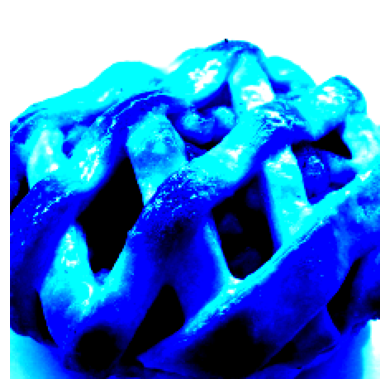

In [6]:
plt.axis(False)
t=train_ds.__getitem__(torch.randint(0,1000,(1,)))
print(t[0].shape)
plt.imshow(t[0].permute(1,2,0))
print(t[1])

In [7]:
torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V1.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [8]:
train_loader=torch.utils.data.DataLoader(train_ds,16,shuffle=True)
val_loader=torch.utils.data.DataLoader(test_ds,16,shuffle=True)

In [9]:
x,y=next(iter(train_loader))
output=torch.argmax(torch.softmax(model(x),dim=1),dim=1)
output

tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0])

In [10]:
y

tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])

In [11]:
loss_fn=nn.CrossEntropyLoss()

In [12]:
with torch.inference_mode():
    logits=model(x)
    torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),torch.argmax(y,dim=1)).sum().item()/len(logits)
    print(loss_fn(torch.squeeze(logits,dim=1),y))

tensor(0.6981)


In [13]:
model=model.to(device)

In [14]:
def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)

def train_model(model,epochs):
    optimizer=torch.optim.Adam(params=model.parameters())
    loss_fn=nn.BCEWithLogitsLoss()
    
    for i in tqdm_notebook(range(epochs)):
        train_preds=torch.tensor([])
        val_preds=torch.tensor([])
        train_actual=torch.tensor([])
        val_actual=torch.tensor([])
        
        print("\nTraining:")
        model.train()
        
        #Defining accuracy and loss for train and val data
        temp_train_accuracy=[]
        temp_val_accuracy=[]
        temp_train_loss=[]
        temp_val_loss=[]
        #temp_train_f1=[]
        #temp_val_f1=[]
    
        net_train_accuracy=0
        net_val_accuracy=0
        net_train_loss=0
        net_val_loss=0
        #net_train_f1=0
        #net_val_f1=0
        
        with tqdm_notebook(total=len(train_loader)) as pbar:
            for x,y in train_loader:
                    x=x.to(device)
                    y=y.to(device)
        
                    #Calculating model output
                    logits=model(x)
        
                    #Reseting any old gradient values
                    optimizer.zero_grad()
                    loss=loss_fn(torch.squeeze(logits,dim=1),y)
                
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    #train_preds=torch.hstack((train_preds,preds.to("cpu")))
                    #train_actual=torch.hstack((train_actual,y.to("cpu")))
                    accuracy_train=accuracy_fn(logits.type(torch.float32),torch.argmax(y,dim=1))
                    #f1_train=f1_fn(preds,y)
                    temp_train_accuracy.append(accuracy_train)
                    temp_train_loss.append(loss.item())
                    #temp_train_f1.append(f1_train.item())
                
                    #Back Propogation
                    loss.backward()
                
                    #Update Parameters
                    optimizer.step()
                
                    #Progress Bar Update
                    pbar.update(1)
            pbar.close()
        #Tensorboard & Metrics for the dataset
        net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
        net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
        #net_train_f1=sum(temp_train_f1)/len(temp_train_f1)
        #writer.add_scalar("Train Accuracy",net_train_accuracy,i)
        #writer.add_scalar("Train Loss",net_train_loss,i)
        #writer.add_scalar("Train F1 Score",net_train_f1,i)
    
        #Evaluation
        print("Testing:")
        model.eval()
    
        with tqdm_notebook(total=len(val_loader)) as pbar2:
            for x,y in val_loader:
                x=x.to(device)
                y=y.to(device)
                
                #Setting inference mode
                with torch.inference_mode():
                    logits=model(x)
                    loss=loss_fn(torch.squeeze(logits,dim=1),y.type(torch.float32))
                    
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    #val_preds=torch.hstack((val_preds,preds.to("cpu")))
                    #val_actual=torch.hstack((val_actual,y.to("cpu")))
                    accuracy_val=accuracy_fn(logits,torch.argmax(y,dim=1))
                    #f1_val=f1_fn(preds,y)
                    temp_val_accuracy.append(accuracy_val)
                    temp_val_loss.append(loss.item())
                    #temp_val_f1.append(f1_val.item())
    
                    #Progress Bar Update
                    pbar2.update(1)
            pbar2.close()
    
        #Tensorboard & Metrics for the dataset
        net_val_accuracy=sum(temp_val_accuracy)/len(temp_val_accuracy)
        net_val_loss=sum(temp_val_loss)/len(temp_val_loss)
        #net_val_f1=sum(temp_val_f1)/len(temp_val_f1)
        #writer.add_scalar("Val Accuracy",net_val_accuracy,i)
        #writer.add_scalar("Val Loss",net_val_loss,i)
        #writer.add_scalar("Val F1 Score",net_val_f1,i)

        
        print(f"\nEpoch {i+1}:\n\nTrain Accuracy: {net_train_accuracy}\n\nTrain Loss: {net_train_loss}\n\nVal Accuracy: {net_val_accuracy}\n\nVal Loss: {net_val_loss}")



In [15]:
train_model(model,10)

  0%|          | 0/10 [00:00<?, ?it/s]


Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 1:

Train Accuracy: 0.8888888888888888

Train Loss: 0.24685222551315314

Val Accuracy: 0.5535714285714286

Val Loss: 12.308928686474998

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 2:

Train Accuracy: 0.9702380952380952

Train Loss: 0.13272163490690883

Val Accuracy: 0.6924603174603174

Val Loss: 1.2874391510609597

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 3:

Train Accuracy: 0.9632936507936508

Train Loss: 0.1365814576265476

Val Accuracy: 0.9305555555555556

Val Loss: 0.2754475915109709

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 4:

Train Accuracy: 0.9732142857142857

Train Loss: 0.10940647514773504

Val Accuracy: 0.9484126984126984

Val Loss: 0.17097192909568548

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 5:

Train Accuracy: 0.9732142857142857

Train Loss: 0.09966220227735383

Val Accuracy: 0.9742063492063492

Val Loss: 0.09692787946689696

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 6:

Train Accuracy: 0.9722222222222222

Train Loss: 0.10834641553579814

Val Accuracy: 0.9732142857142857

Val Loss: 0.1447548775800637

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 7:

Train Accuracy: 0.9692460317460317

Train Loss: 0.10755092182034065

Val Accuracy: 0.7936507936507936

Val Loss: 0.8007593159637754

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 8:

Train Accuracy: 0.9821428571428571

Train Loss: 0.07301076185993022

Val Accuracy: 0.9652777777777778

Val Loss: 0.10434895763469357

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 9:

Train Accuracy: 0.9821428571428571

Train Loss: 0.06617355001868591

Val Accuracy: 0.9751984126984127

Val Loss: 0.12121089523203582

Training:


  0%|          | 0/63 [00:00<?, ?it/s]

Testing:


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 10:

Train Accuracy: 0.9910714285714286

Train Loss: 0.040890584888291504

Val Accuracy: 0.9771825396825397

Val Loss: 0.14281514613650784


In [17]:
x,y=next(iter(val_loader))
x=x.to(device)
y=y.to(device)

In [18]:
with torch.inference_mode():
    output=torch.argmax(torch.softmax(model(x),dim=1),dim=1)
    print(output)

tensor([0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')


In [21]:
torch.argmax(y,dim=1)

tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')